# Proyecto Machine Learning

**Integrantes:**
- Jose Andrés Jaramillo
- David Parra
- Daniela Martinez Quiroga
- María Isabella Rodríguez Arévalo

**Idea de uso:**
1. *Aprendizaje supersivado:* Predecir los consumidores de una red en Cartagena


## Librerías

In [ ]:
!pip install -U ydata_profiling
!pip install keras-tuner -q

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
import keras_tuner as kt
import numpy as np

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperParameters

## Cargar CSV y Reporte

In [ ]:
df = pd.read_csv('Wifi-Cartagena.csv')
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:00<00:00, 34.10it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **Proyecto 1**
### **Análisis**
1. Teniendo en cuenta la matriz de correlación, todas las variables tienen excepto Corregimiento/Barrio y Fecha, determinando que las variables no son influyentes en el modelo. Asimismo, las variables mostradas en la matriz tienen una relación positiva (por encima de cero) al estar todas en tonos azules.
2. Como se va a predecir la variable numérica "consumidores" de acuerdo con la idea, nuestros modelos van a predecir valores numéricos

## Limpieza

Se numerizó la variable "Zona Wifi" para un fácil manejo en los modelos a crear

In [ ]:
#Separate X and Y set
x = df.drop(['Zona Wifi', 'Corregimiento/Barrio', 'Fecha', 'Consumidores'], axis=1)
y = df['Consumidores']

#Delete nulls
x.fillna(x.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)
x['Zona Wifi'] = df['Zona Wifi'].astype('category').cat.codes

#Separate train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

x

Visitas  Logins  Dispositivos Nuevos  Sesiones  Zona Wifi
0           0       0                    0         0          4
1           0       0                    0         0          4
2           0       0                    0         0          4
3           0       0                    0         0          4
4           0       0                    0         0          4
...       ...     ...                  ...       ...        ...
4198       42      40                   18       332         14
4199      107      91                   37      1137         14
4200       80      62                   31       698         14
4201       33      24                   17       207         14
4202       28      25                   19       369         14

[4203 rows x 5 columns]

### Boxplot

Se realizará el gráfico boxplot/caja y bigotes para si se presentan outliers. En caso de que hayan, se van a delimitar los modelos a usar para no eliminar los datos

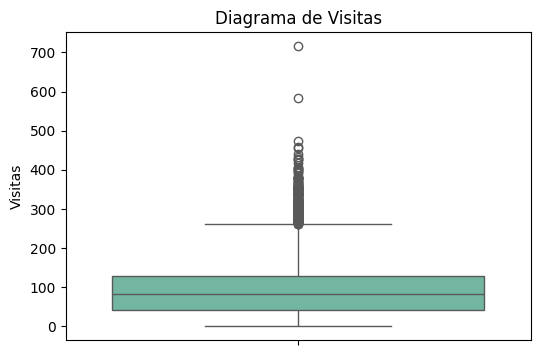

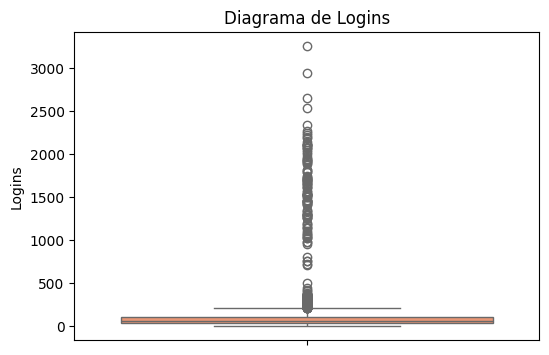

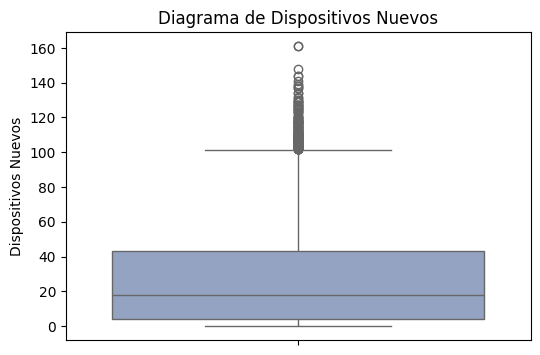

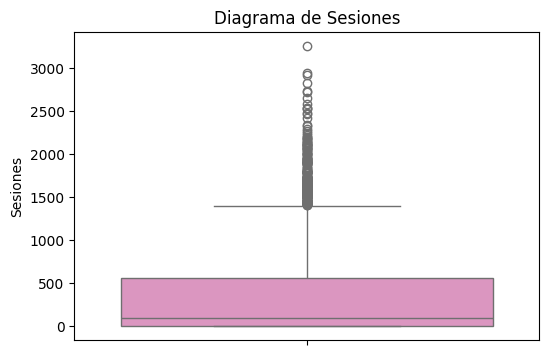

In [ ]:
columns = ['Visitas', 'Logins', 'Dispositivos Nuevos', 'Sesiones']
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']  # You can change these hex codes

for col, color in zip(columns, colors):
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=x, y=col, color=color)
    plt.title(f'Diagrama de {col}')
    plt.show()

Observando los boxplots, se puede concluir que al haber bastantes outliers en todas las variables, se recomienda no eliminarlas y seguir con modelos que los manejen bien. Por lo tanto, se realizará: árbol de decisión, ensambles y redes neuronales

## Modelos

### Árbol de decisión

In [ ]:
param = {
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'max_depth': [None, 5, 10, 15, 20],
    'max_features': [0.3, 0.5, 0.7],
    'max_leaf_nodes': [None, 5, 10, 15, 20],
    'min_impurity_decrease': [0.0, 0.0001, 0.0002],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [10, 20, 30],
}

random_search_tree = RandomizedSearchCV(DecisionTreeRegressor(), param, cv=5, scoring='neg_mean_squared_error', n_iter=10, random_state=42)
random_search_tree.fit(x_train, y_train)
print(random_search_tree.best_params_)

{'min_samples_split': 20, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0002, 'max_leaf_nodes': 15, 'max_features': 0.7, 'max_depth': None, 'criterion': 'friedman_mse'}


In [ ]:
y_pred_tree_t = random_search_tree.predict(x_test)
y_pred_tree_tr = random_search_tree.predict(x_train)
MSE_train = mean_squared_error(y_train, y_pred_tree_tr)
MSE_test = mean_squared_error(y_test, y_pred_tree_t)
RMSE_train = MSE_train**0.5
RMSE_test = MSE_test**0.5
print(f'Tree\'s MSE test: {MSE_test}')
print(f'Tree\'s MSE train: {MSE_train}')
print(f'Tree\'s RMSE test: {RMSE_test}')
print(f'Tree\'s RMSE train: {RMSE_train}')

Tree's MSE test: 34.639160505739454
Tree's MSE train: 31.687368901515434
Tree's RMSE test: 5.885504269452147
Tree's RMSE train: 5.629153480010599


#### Análisis del árbol de decisión

El modelo generado por el algoritmo del árbol de decisión brinda un error de 6.50 consumidores en los datos de prueba y un 6.08 consumidores en los datos de entrenamiento. Esto indica que el modelo no tiene sobreajuste y que en promedio se equivoca 6 consumidores

### Red neuronal

In [ ]:
def build_model(hp):
  model = Sequential([
        Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
              activation='relu',
              kernel_regularizer=l2(0.001)),
        Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
              activation='relu',
              kernel_regularizer=l2(0.001)),
        Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32),
              activation='relu',
              kernel_regularizer=l2(0.001)),
        Dense(units=hp.Int('units_4', min_value=32, max_value=512, step=32),
              activation='relu',
              kernel_regularizer=l2(0.001)),
        Dense(units=hp.Int('units_5', min_value=32, max_value=512, step=32),
              activation='relu',
              kernel_regularizer=l2(0.001)),
        Dense(units=1, activation='linear', kernel_regularizer=l2(0.001))
    ])
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mae'])
  return model

model_begin = kt.Hyperband(
       build_model,
       objective='val_loss',
       max_epochs=25,
       factor=3,
       seed=42,
       max_consecutive_failed_trials=5
   )

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model_begin.search(x_train, y_train, epochs=10, validation_split=0.2, verbose=0)
best_hps_model = model_begin.get_best_hyperparameters(num_trials=1)[0]
print("Mejores hiperparámetros encontrados:")
for param, value in best_hps_model.values.items():
    print(f"{param}: {value}")

model_final = model_begin.hypermodel.build(best_hps_model)
model_final.fit(x_train, y_train, epochs=25, validation_split=0.2, shuffle=False)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved op

Mejores hiperparámetros encontrados:
units_1: 224
units_2: 256
units_3: 256
units_4: 352
units_5: 320
tuner/epochs: 25
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 651.1952 - mae: 16.3841 - val_loss: 127.7520 - val_mae: 7.5372
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 93.8474 - mae: 6.2778 - val_loss: 40.3254 - val_mae: 3.9210
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 36.8219 - mae: 3.8347 - val_loss: 30.5679 - val_mae: 3.3614
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 27.4006 - mae: 3.2822 - val_loss: 24.9617 - val_mae: 3.0038
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.0782 - mae: 3.0340 - val_loss: 21.4174 - val_mae: 2.7676
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 19.9068 - mae: 2.8264 - val_loss: 19.5375 - val_mae: 2.5863
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 18.2633 - mae: 2.6851 - val_loss: 18.6656 - val_mae: 2.5

In [ ]:
y_pred_mod_t = model_final.predict(x_test)
y_pred_mod_tr = model_final.predict(x_train)

y_pred_mod_t = y_pred_mod_t.argmax(axis=1)
y_pred_mod_tr = y_pred_mod_tr.argmax(axis=1)

MSE_train = mean_squared_error(y_train, y_pred_mod_tr)
MSE_test = mean_squared_error(y_test, y_pred_mod_t)
RMSE_train = MSE_train**0.5
RMSE_test = MSE_test**0.5

print(f'Tree\'s MSE test: {MSE_test}')
print(f'Tree\'s MSE train: {MSE_train}')
print(f'Tree\'s RMSE test: {RMSE_test}')
print(f'Tree\'s RMSE train: {RMSE_train}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Tree's MSE test: 1108.890718767466
Tree's MSE train: 1132.4010876954453
Tree's RMSE test: 33.300010792302544
Tree's RMSE train: 33.65116770181156


#### Análisis de la red neuronal

El modelo generado por el algoritmo del árbol de decisión brinda un error de 33.30 consumidores en los datos de prueba y un 33.65 consumidores en los datos de entrenamiento. Esto indica que el modelo no tiene sobreajuste pero que el error es alto al equivocarse en alrededor en 33 consumidores indicando que no es el más adecuado

### Random forest regressor

In [ ]:
# Definir los hiperparámetros a probar
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

# Modelo base
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV para optimización
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   scoring='neg_mean_squared_error', n_iter=20, cv=5, verbose=2,
                                   random_state=42, n_jobs=-1)

# Entrenar la búsqueda de hiperparámetros
random_search.fit(x_train, y_train)

# Mejor modelo
best_rf = random_search.best_estimator_
y_pred_tree_tr = best_rf.predict(x_train)
y_pred_tree_t = best_rf.predict(x_test)

# Evaluación en entrenamiento y prueba
MSE_train = mean_squared_error(y_train, y_pred_tree_tr)
MSE_test = mean_squared_error(y_test, y_pred_tree_t)

RMSE_train = MSE_train**0.5
RMSE_test = MSE_test**0.5
print("RANDOM FOREST CLASSIFIER")
print(f"Mejores hiperparámetros: {random_search.best_params_}")
print(f"MSE train: {MSE_train}")
print(f"MSE test: {MSE_test}")
print(f"RMSE train: {RMSE_train}")
print(f"RMSE test: {RMSE_test}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RANDOM FOREST CLASSIFIER
Mejores hiperparámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
MSE train: 1.569401513958418
MSE test: 12.447537854258332
RMSE train: 1.2527575639198585
RMSE test: 3.5281068371377775


In [ ]:
import joblib

# Guardar el mejor modelo entrenado
joblib.dump(best_rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

## Conclusiones

1. Se seleccionó el modelo random forest por sus RMSE; tanto en los datos de entrenamiento y prueba son menores comparados con los otros dos modelos

2. Ninguno de los 3 modelos presentan sobreajuste al no tener su RMSE de entrenamiento cerca de cero y el de prueba más alto

3. En la red neuronal se estableció que la cantidad ideal de capas son 6 por ser un factor importante al evaluar el MSE y el RMSE en gran cantidad

# **Proyecto 2**

*Objetivo:* Predecir la variable "Zona Wifi" por medio de clustering

## Librerías importadas

In [ ]:
#PCA
from sklearn.decomposition import PCA

#DBSCAN
from sklearn.cluster import DBSCAN

#Metrics
from sklearn.metrics import silhouette_score

#Escalar datos
from sklearn.preprocessing import MinMaxScaler

#Gaussian Mixture
from sklearn.mixture import GaussianMixture

#K means
from sklearn.cluster import KMeans

#Búsqueda de hiperparámetros
from sklearn.model_selection import ParameterGrid

#Diagramas en 3D
from mpl_toolkits.mplot3d import Axes3D

## Inicialización datos

In [ ]:
x_2 = df.drop(['Zona Wifi','Corregimiento/Barrio','Fecha'], axis=1)
x_2.fillna(x_2.mean(), inplace=True)
x_2['Zona Wifi'] = df['Zona Wifi'].astype('category').cat.codes
scale = MinMaxScaler().fit(x_2)
x_2 = scale.transform(x_2)

## PCA

En este paso se desea transformar los datos con PCA, por lo mismo se va a identificar cuál es la cantidad ideal de componentes por medio de la regla del codo.

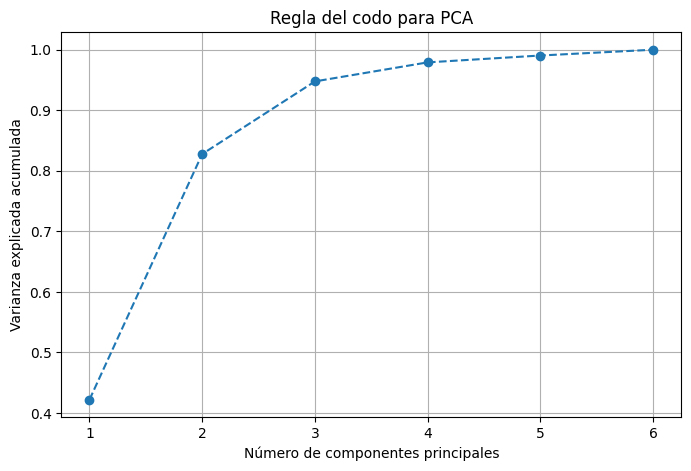

In [ ]:
#Realizar PCA
pca = PCA()
pca.fit(x_2)

#Varianza
varianza = np.cumsum(pca.explained_variance_ratio_)

#Diagrama de codo
plt.figure(figsize=(8,5))
plt.plot(range(1, len(varianza)+1), varianza, marker='o', linestyle='--')
plt.title('Regla del codo para PCA')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()


Después de observar el diagrama, para PCA se va a usar 3 componentes por la regla de codo

In [ ]:
pca_final = PCA(n_components=3)
x_2_pca = pca_final.fit_transform(x_2)

## Modelos

Los modelos se van a entrenar con el método DBSCAN, Gaussian mixture y K Means teniendo en cuenta que es lo propuesto para este entregable usar modelos no supervisados. Para cada uno se hará modelos con los datos tranformados por PCA y sin PCA

### *DBSCAN*

A continuación se observan algunos hiperparámetros con los cuales se hará la busqueda de los mejores

In [ ]:
param_dbscan = {
    'eps': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9],
    'min_samples': [4, 5, 6, 7]
}

**Datos sin pasar por PCA**

In [ ]:
score = 0
best_params ={}

#Buscar los mejores hiperparámetros
for params in ParameterGrid(param_dbscan):
  print(params)
  dbscan = DBSCAN(**params, metric='manhattan')
  labels = dbscan.fit_predict(x_2)

  # Evitar usar silhouette si hay 1 solo cluster o todos son ruido
  if len(set(labels)) <= 1 or (set(labels) == {-1}):
    continue

  score_f = silhouette_score(x_2, labels, metric='manhattan')
  print(f"score: {score_f}")
  if score_f > score:
    score = score_f
    best_params = params

print(f"Mejor valor de eps: {best_params['eps']}")
print(f"Mejor valor de min_samples: {best_params['min_samples']}")

{'eps': 0.1, 'min_samples': 4}
score: -0.06738165881218804
{'eps': 0.1, 'min_samples': 5}
score: -0.07270032582037884
{'eps': 0.1, 'min_samples': 6}
score: -0.07716636493718586
{'eps': 0.1, 'min_samples': 7}
score: -0.07340874259869733
{'eps': 0.2, 'min_samples': 4}
score: 0.31003825975515475
{'eps': 0.2, 'min_samples': 5}
score: 0.2919338595654662
{'eps': 0.2, 'min_samples': 6}
score: 0.41008196006686526
{'eps': 0.2, 'min_samples': 7}
score: 0.4322595418236289
{'eps': 0.3, 'min_samples': 4}
score: 0.24155929071950924
{'eps': 0.3, 'min_samples': 5}
score: 0.2414757589686081
{'eps': 0.3, 'min_samples': 6}
score: 0.24258302827767575
{'eps': 0.3, 'min_samples': 7}
score: 0.24258302827767575
{'eps': 0.4, 'min_samples': 4}
score: 0.46596583636973354
{'eps': 0.4, 'min_samples': 5}
score: 0.46596583636973354
{'eps': 0.4, 'min_samples': 6}
score: 0.46596583636973354
{'eps': 0.4, 'min_samples': 7}
score: 0.46596583636973354
{'eps': 0.5, 'min_samples': 4}
{'eps': 0.5, 'min_samples': 5}
score: 0.

In [ ]:
dbscan_no_pca = DBSCAN(**best_params, metric='manhattan')
labels = dbscan_no_pca.fit_predict(x_2)
sil_dbscan_no_pca = silhouette_score(x_2, labels, metric='manhattan')
num_clusters_dbscan = len(set(labels))
num_ruido_dbscan = list(labels).count(-1)
print(f"Número de clusters: {num_clusters_dbscan}")
print(f"Número de elementos en ruido: {num_ruido_dbscan}")
print(f"Silhouette score: {sil_dbscan_no_pca}")

Número de clusters: 2
Número de elementos en ruido: 2
Silhouette score: 0.48268295601381295


Ahora con el modelo vamos a visualizar en un diagrama cómo se visualizan los clusters

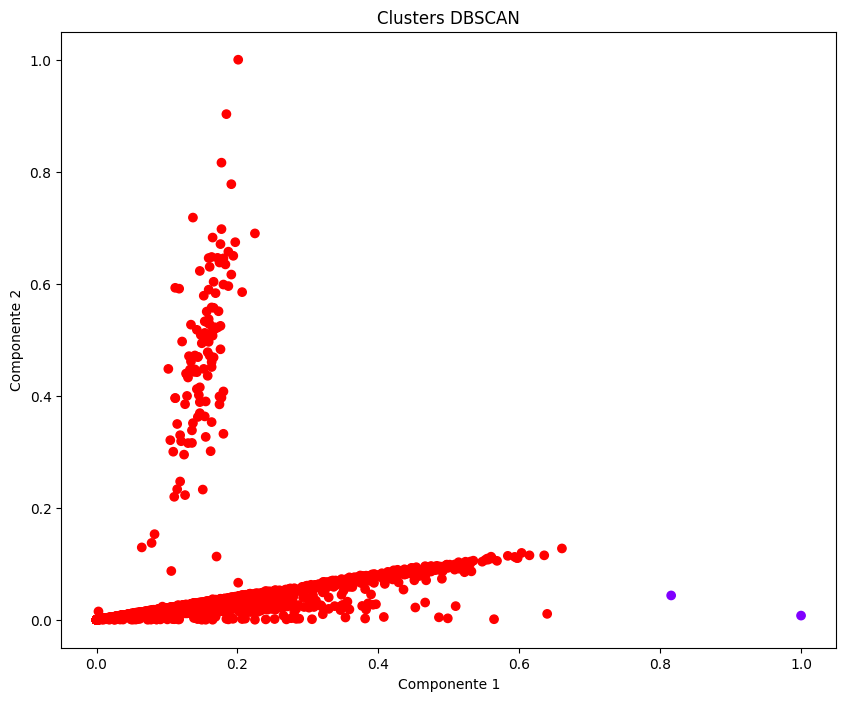

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(x_2[:,0], x_2[:,1], c=labels, cmap='rainbow')
plt.title('Clusters DBSCAN')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

**Datos con PCA**

In [ ]:
score_pca = 0
best_params_pca ={}

#Buscar los mejores hiperparámetros
for params in ParameterGrid(param_dbscan):
  print(params)
  dbscan = DBSCAN(**params, metric='manhattan')
  labels = dbscan.fit_predict(x_2_pca)

  # Evitar usar silhouette si hay 1 solo cluster o todos son ruido
  if len(set(labels)) <= 1 or (set(labels) == {-1}):
    continue

  score_f = silhouette_score(x_2_pca, labels, metric='manhattan')
  print(f"score: {score_f}")
  if score_f > score_pca:
    score_pca = score_f
    best_params_pca = params

print(f"Mejor valor de eps: {best_params_pca['eps']}")
print(f"Mejor valor de min_samples: {best_params_pca['min_samples']}")

{'eps': 0.1, 'min_samples': 4}
score: 0.15285764710318905
{'eps': 0.1, 'min_samples': 5}
score: 0.1663184422022458
{'eps': 0.1, 'min_samples': 6}
score: 0.16665689418742338
{'eps': 0.1, 'min_samples': 7}
score: 0.16672953506331947
{'eps': 0.2, 'min_samples': 4}
score: 0.2729390868480594
{'eps': 0.2, 'min_samples': 5}
score: 0.2729390868480594
{'eps': 0.2, 'min_samples': 6}
score: 0.27330047930046913
{'eps': 0.2, 'min_samples': 7}
score: 0.3316108204373847
{'eps': 0.3, 'min_samples': 4}
score: 0.2997241728184892
{'eps': 0.3, 'min_samples': 5}
score: 0.2997241728184892
{'eps': 0.3, 'min_samples': 6}
score: 0.2997241728184892
{'eps': 0.3, 'min_samples': 7}
score: 0.2997241728184892
{'eps': 0.4, 'min_samples': 4}
{'eps': 0.4, 'min_samples': 5}
score: 0.44944757704274
{'eps': 0.4, 'min_samples': 6}
score: 0.44944757704274
{'eps': 0.4, 'min_samples': 7}
score: 0.44944757704274
{'eps': 0.5, 'min_samples': 4}
{'eps': 0.5, 'min_samples': 5}
{'eps': 0.5, 'min_samples': 6}
{'eps': 0.5, 'min_sampl

In [ ]:
dbscan_pca = DBSCAN(**best_params_pca, metric='manhattan')
labels_pca = dbscan_pca.fit_predict(x_2_pca)
sil_dbscan_pca = silhouette_score(x_2_pca, labels_pca, metric='manhattan')
num_clusters_dbscan_pca = len(set(labels_pca))
num_ruido_dbscan_pca = list(labels_pca).count(-1)
print(f"Número de clusters: {num_clusters_dbscan_pca}")
print(f"Número de elementos en ruido: {num_ruido_dbscan_pca}")
print(f"Silhouette score: {sil_dbscan_pca}")

Número de clusters: 2
Número de elementos en ruido: 2
Silhouette score: 0.44944757704274


Teniendo un modelo, ahora procedemos a graficar

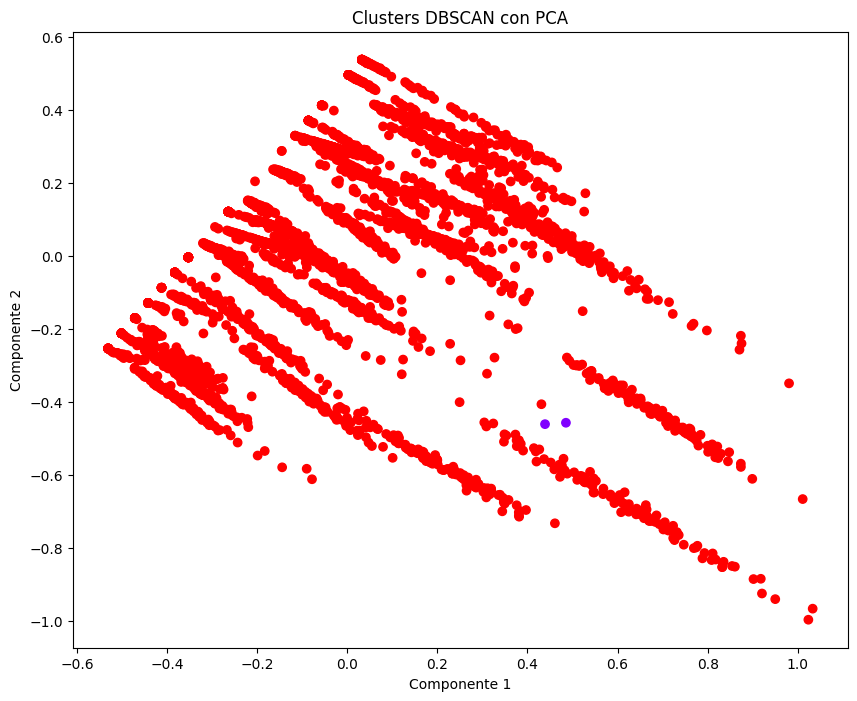

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(x_2_pca[:,0], x_2_pca[:,1], c=labels_pca, cmap='rainbow')
plt.title('Clusters DBSCAN con PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()


Hipótesis para el análisis del efecto de PCA sobre DBSCAN

Hipótesis nula (H₀):
La aplicación de reducción de dimensionalidad mediante PCA no tiene un impacto significativo en la calidad del clustering generado por el algoritmo DBSCAN.

Hipótesis alternativa (H₁):
La aplicación de PCA mejora significativamente la calidad del clustering generado por DBSCAN.

| Configuración | Número de clusters | Puntos clasificados como ruido | Silhouette Score |
| ------------- | ------------------ | ------------------------------ | ---------------- |
| Sin PCA       | 2                  | 2                              | 0.4827           |
| Con PCA       | 2                  | 2                              | 0.4494           |

Conclusión

Los resultados muestran que tanto con como sin PCA, el algoritmo DBSCAN identifica exactamente dos clusters y clasifica dos puntos como ruido. Sin embargo, el Silhouette Score es ligeramente menor al aplicar PCA (0.4494 frente a 0.4827), lo que indica que los clusters formados son ligeramente menos cohesivos y menos separados tras la reducción de dimensionalidad.

Por lo tanto, no se evidencia una mejora en la calidad del clustering al aplicar PCA antes de usar DBSCAN. A partir de estos resultados, se concluye que no se rechaza la hipótesis nula (H₀). Es decir, en este caso particular, el uso de PCA no aporta un beneficio significativo en el rendimiento del algoritmo DBSCAN para la segmentación de zonas WiFi.

### *Gaussian Mixture*

In [ ]:
param_gaussian = {
    'n_components': [2, 3, 4, 5, 6],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'random_state': [42]
}

**Datos sin pasar por PCA**

In [ ]:
score_g = 0
best_params_g ={}

#Buscar los mejores hiperparámetros
for params in ParameterGrid(param_gaussian):
  print(params)
  gaussian = GaussianMixture(**params)
  labels = gaussian.fit_predict(x_2)

  # Evitar usar silhouette si hay 1 solo cluster o todos son ruido
  if len(set(labels)) <= 1 or (set(labels) == {-1}):
    continue

  score_f = silhouette_score(x_2, labels, metric='manhattan')
  print(f"score: {score_f}")
  if score_f > score_g:
    score_g = score_f
    best_params_g = params

print(f"Mejor valor de eps: {best_params_g['n_components']}")
print(f"Mejor valor de min_samples: {best_params_g['covariance_type']}")

{'covariance_type': 'full', 'n_components': 2, 'random_state': 42}
score: 0.39856755232573277
{'covariance_type': 'full', 'n_components': 3, 'random_state': 42}
score: 0.14976246108350308
{'covariance_type': 'full', 'n_components': 4, 'random_state': 42}
score: 0.18512446519774495
{'covariance_type': 'full', 'n_components': 5, 'random_state': 42}
score: 0.19336836315023587
{'covariance_type': 'full', 'n_components': 6, 'random_state': 42}
score: 0.24380776189976133
{'covariance_type': 'tied', 'n_components': 2, 'random_state': 42}
score: 0.2596563246244872
{'covariance_type': 'tied', 'n_components': 3, 'random_state': 42}
score: 0.3133873016706412
{'covariance_type': 'tied', 'n_components': 4, 'random_state': 42}
score: 0.2763592400236675
{'covariance_type': 'tied', 'n_components': 5, 'random_state': 42}
score: 0.31008186070569355
{'covariance_type': 'tied', 'n_components': 6, 'random_state': 42}
score: 0.32006451572303257
{'covariance_type': 'diag', 'n_components': 2, 'random_state': 

In [ ]:
gaussian_n = GaussianMixture(**best_params_g)
labels_g= gaussian_n.fit_predict(x_2)
sil_gaussian_no_pca = silhouette_score(x_2, labels_g, metric='manhattan')
num_clusters_gaussian = len(set(labels_g))
num_ruido_gaussian = list(labels_g).count(-1)
print(f"Número de clusters: {num_clusters_gaussian}")
print(f"Número de elementos en ruido: {num_ruido_gaussian}")
print(f"Silhouette score: {sil_gaussian_no_pca}")

Número de clusters: 2
Número de elementos en ruido: 0
Silhouette score: 0.39856755232573277


Con el modelo, se procede a visualizar los clusters

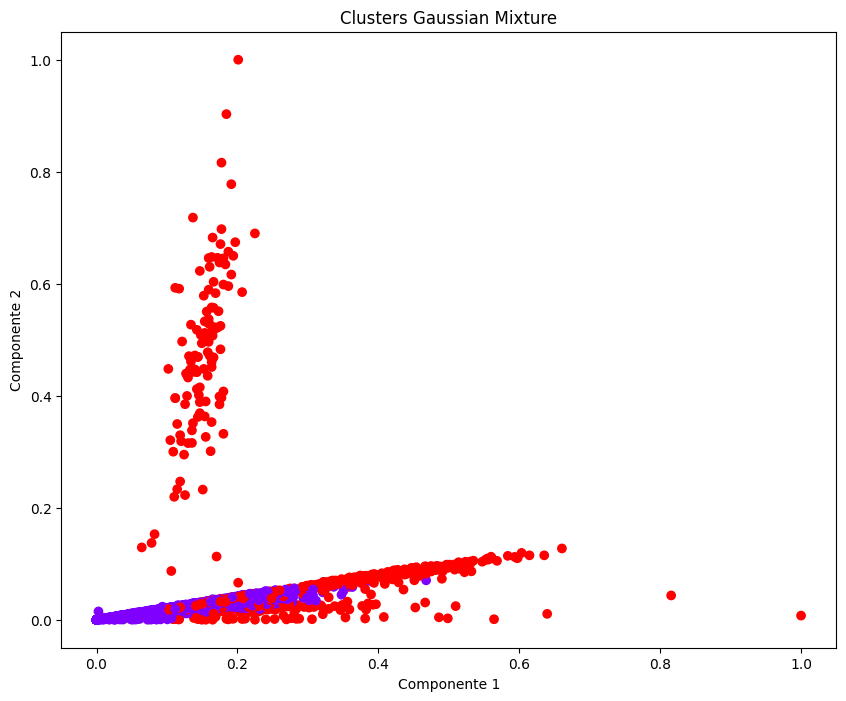

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(x_2[:,0], x_2[:,1], c=labels_g, cmap='rainbow')
plt.title('Clusters Gaussian Mixture')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

**Datos con PCA**

In [ ]:
score_g_pca = 0
best_params_g_pca ={}

#Buscar los mejores hiperparámetros
for params in ParameterGrid(param_gaussian):
  print(params)
  gaussian = GaussianMixture(**params)
  gaussian.fit(x_2_pca)
  labels = gaussian.predict(x_2_pca)

  # Evitar usar silhouette si hay 1 solo cluster o todos son ruido
  if len(set(labels)) <= 1 or (set(labels) == {-1}):
    continue

  score_f = silhouette_score(x_2_pca, labels, metric='manhattan')
  print(f"score: {score_f}")
  if score_f > score_g_pca:
    score_g_pca = score_f
    best_params_g_pca = params

print(f"Mejor valor de eps: {best_params_g_pca['n_components']}")
print(f"Mejor valor de min_samples: {best_params_g_pca['covariance_type']}")

{'covariance_type': 'full', 'n_components': 2, 'random_state': 42}
score: 0.13977518720376617
{'covariance_type': 'full', 'n_components': 3, 'random_state': 42}
score: 0.33116699816390377
{'covariance_type': 'full', 'n_components': 4, 'random_state': 42}
score: 0.12944770141045478
{'covariance_type': 'full', 'n_components': 5, 'random_state': 42}
score: 0.1357554230793594
{'covariance_type': 'full', 'n_components': 6, 'random_state': 42}
score: 0.13902469668794878
{'covariance_type': 'tied', 'n_components': 2, 'random_state': 42}
score: 0.30080554030611795
{'covariance_type': 'tied', 'n_components': 3, 'random_state': 42}
score: 0.38149200939907624
{'covariance_type': 'tied', 'n_components': 4, 'random_state': 42}
score: 0.3139301855671817
{'covariance_type': 'tied', 'n_components': 5, 'random_state': 42}
score: 0.344965486953745
{'covariance_type': 'tied', 'n_components': 6, 'random_state': 42}
score: 0.3370388774320538
{'covariance_type': 'diag', 'n_components': 2, 'random_state': 42

In [ ]:
gaussian_pca = GaussianMixture(**best_params_g_pca)
labels_g_pca= gaussian_pca.fit_predict(x_2_pca)
sil_gaussian_pca = silhouette_score(x_2_pca, labels_g_pca, metric='manhattan')
num_clusters_gaussian_pca = len(set(labels_g_pca))
num_ruido_gaussian_pca = list(labels_g_pca).count(-1)
print(f"Número de clusters: {num_clusters_gaussian_pca}")
print(f"Número de elementos en ruido: {num_ruido_gaussian_pca}")
print(f"Silhouette score: {sil_gaussian_pca}")

Número de clusters: 3
Número de elementos en ruido: 0
Silhouette score: 0.38618174206745653


Con el modelo, procedemos a realizar el diagrama de dispersión

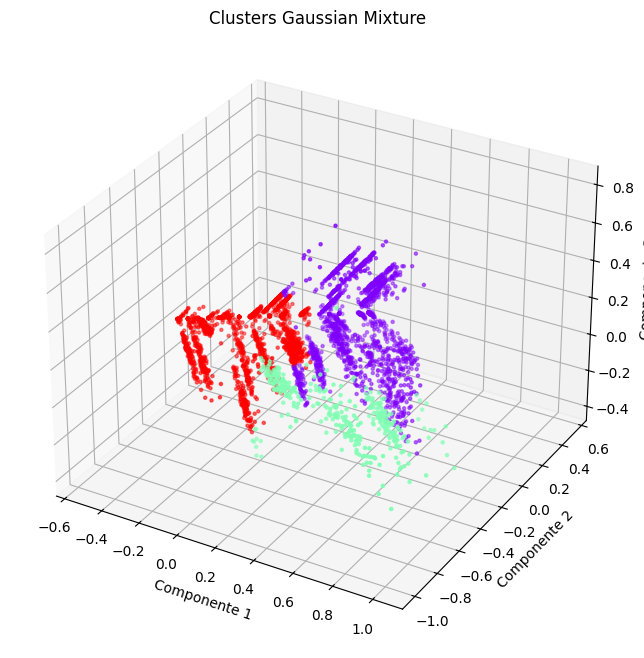

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_2_pca[:,0], x_2_pca[:,1], x_2_pca[:,2], c=labels_g_pca, cmap='rainbow', s=5)
ax.set_title('Clusters Gaussian Mixture')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.show()

Hipótesis para Gaussian Mixture y PCA

Hipótesis nula (H₀):
La aplicación de reducción de dimensionalidad mediante PCA no tiene un impacto significativo en la calidad del clustering generado por el algoritmo Gaussian Mixture.

Hipótesis alternativa (H₁):
La aplicación de PCA mejora significativamente la calidad del clustering generado por Gaussian Mixture.

Resultados observados

| Configuración | Número de clusters | Puntos ruido | Silhouette Score |
| ------------- | ------------------ | ------------ | ---------------- |
| **Sin PCA**   | 2                  | 0            | **0.3986**       |
| **Con PCA**   | 3                  | 0            | **0.3862**       |


Análisis e interpretación

Al aplicar PCA, el modelo pasó de 2 a 3 clusters, lo cual sugiere una mayor capacidad para identificar subgrupos.

Sin embargo, el Silhouette Score disminuyó ligeramente, de 0.3986 a 0.3862, lo que indica que los nuevos clusters no son más compactos ni mejor separados.

Visualmente, con PCA se observa una segmentación más clara en 3D, aunque cuantitativamente no representa una mejora en cohesión/separación.

Conclusión

Aunque el modelo Gaussian Mixture con PCA logró detectar más clusters, la ligera disminución del Silhouette Score indica que la calidad de la agrupación no mejoró significativamente.

Por tanto, no se rechaza la hipótesis nula (H₀). Es decir, en este caso, la aplicación de PCA no contribuye a una mejora sustancial en el rendimiento del algoritmo Gaussian Mixture en términos de calidad del clustering.



### *K-Means*

Para la siguiente parte, como no conocemos la cantidad ideal de clusters para el modelo, se hará una busqueda con la regla de codo y el método silueta

**Datos con varianza sin PCA**

In [ ]:
inertias = []
centroids_list = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    label = kmeans.fit_predict(x_2)
    inertias.append(kmeans.inertia_)
    centroids_list.append(kmeans.cluster_centers_)
    print(f'K = {k}')
    print('Centroides:\n', kmeans.cluster_centers_)
    print('Inercia:', kmeans.inertia_)
    print(f"Silhouette score: {silhouette_score(x_2, label, metric='manhattan')}")
    print('-' * 50)

K = 2
Centroides:
 [[0.14133007 0.02299728 0.2490383  0.10688765 0.13752798 0.76136155]
 [0.12747212 0.04651598 0.12431128 0.10805004 0.15094195 0.30308695]]
Inercia: 562.8446963588817
Silhouette score: 0.2765963908940027
--------------------------------------------------
K = 3
Centroides:
 [[0.12281609 0.01950642 0.22417567 0.07391956 0.10056521 0.77160792]
 [0.09868702 0.04395148 0.07112793 0.07762229 0.10269052 0.30986742]
 [0.37477587 0.067488   0.57579452 0.42885857 0.57965907 0.40443948]]
Inercia: 358.166111467026
Silhouette score: 0.33784049307558794
--------------------------------------------------
K = 4
Centroides:
 [[0.13184143 0.02058653 0.26194389 0.07722276 0.10704094 0.79726221]
 [0.08310936 0.01508713 0.08293752 0.05861385 0.08136309 0.48562583]
 [0.11910897 0.08192203 0.03879251 0.1077476  0.13103465 0.13198095]
 [0.37942657 0.06861985 0.58530534 0.42937437 0.58594849 0.39480934]]
Inercia: 294.23576473294787
Silhouette score: 0.280895818873631
-------------------------

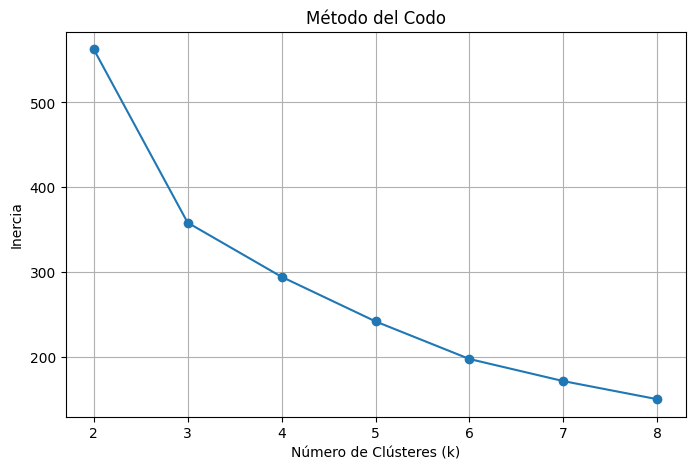

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 9), inertias, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

Gracias al diagrama de codo, concluimos en usar 3 componentes para PCA

In [ ]:
kmeans_normal = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans_normal = kmeans_normal.fit_predict(x_2)
sil_kmeans_no_pca = silhouette_score(x_2, labels_kmeans_normal, metric='manhattan')
num_clusters_kmeans = len(set(labels_kmeans_normal))
num_ruido_kmeans = list(labels_kmeans_normal).count(-1)
print(f"Número de clusters: {num_clusters_kmeans}")
print(f"Número de elementos en ruido: {num_ruido_kmeans}")
print(f"Inercia: {kmeans_normal.inertia_}")
print(f"Silhouette score: {sil_kmeans_no_pca}")

Número de clusters: 3
Número de elementos en ruido: 0
Inercia: 358.166111467026
Silhouette score: 0.33784049307558794


Con el modelo definido, se realiza el siguiente diagrama de dispersión

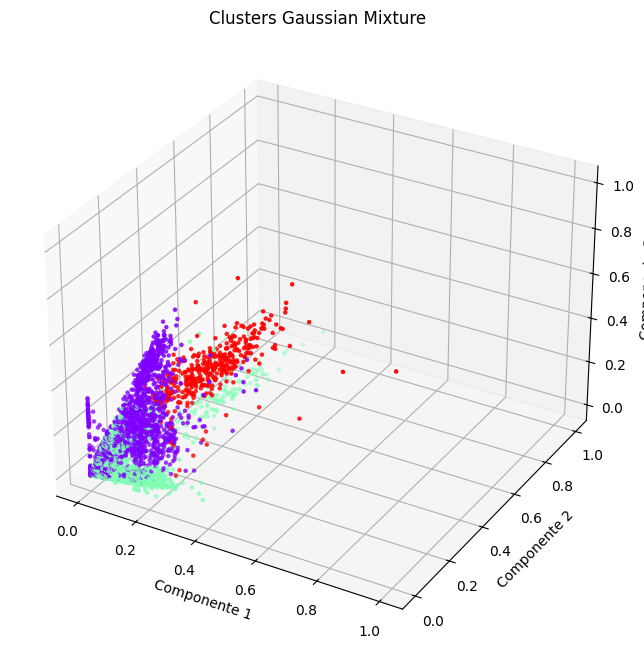

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_2[:,0], x_2[:,1], x_2[:,2], c=labels_kmeans_normal, cmap='rainbow', s=5)
ax.set_title('Clusters Gaussian Mixture')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.show()

**Datos con PCA**

In [ ]:
inertias_pca = []
centroids_list_pca = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    label = kmeans.fit_predict(x_2_pca)
    inertias_pca.append(kmeans.inertia_)
    centroids_list_pca.append(kmeans.cluster_centers_)
    print(f'K = {k}')
    print('Centroides:\n', kmeans.cluster_centers_)
    print('Inercia:', kmeans.inertia_)
    print(f"Silhouette score: {silhouette_score(x_2_pca, label, metric='manhattan')}")
    print('-' * 50)

K = 2
Centroides:
 [[ 0.19261813  0.13460141  0.00811276]
 [-0.19829158 -0.13856601 -0.00835172]]
Inercia: 519.2637442563074
Silhouette score: 0.3163028142620858
--------------------------------------------------
K = 3
Centroides:
 [[-0.21983293 -0.11456523 -0.01312456]
 [ 0.51313553 -0.50467349  0.02478017]
 [ 0.12966987  0.22466222  0.00893288]]
Inercia: 316.53713815897305
Silhouette score: 0.3920926400665807
--------------------------------------------------
K = 4
Centroides:
 [[ 0.1696954   0.23431437  0.03026824]
 [-0.13400401  0.04421987 -0.02795201]
 [-0.30995471 -0.27997985 -0.02025751]
 [ 0.51689539 -0.50794916  0.02733245]]
Inercia: 253.41890838687175
Silhouette score: 0.31926079990525164
--------------------------------------------------
K = 5
Centroides:
 [[-0.15205661  0.0385134  -0.01735876]
 [ 0.19458983  0.17531499  0.29537747]
 [ 0.52360085 -0.51987435  0.02278636]
 [-0.30602218 -0.28771926 -0.02156187]
 [ 0.14767499  0.24210467 -0.09403465]]
Inercia: 201.4714266618764

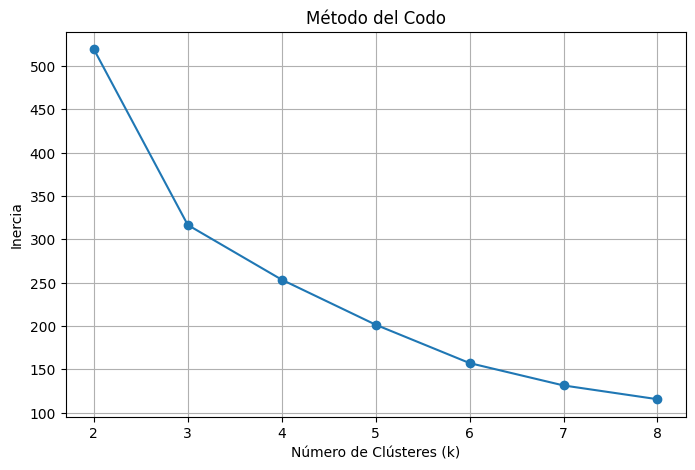

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 9), inertias_pca, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

Gracias al diagrama de codo, concluimos en usar 3 componentes para PCA

In [ ]:
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans_pca = kmeans_pca.fit_predict(x_2_pca)
sil_kmeans_pca = silhouette_score(x_2_pca, labels_kmeans_pca, metric='manhattan')
num_clusters_kmeans_pca = len(set(labels_kmeans_pca))
num_ruido_kmeans_pca = list(labels_kmeans_pca).count(-1)
print(f"Número de clusters: {num_clusters_kmeans_pca}")
print(f"Número de elementos en ruido: {num_ruido_kmeans_pca}")
print(f"Inercia: {kmeans_pca.inertia_}")
print(f"Silhouette score: {sil_kmeans_pca}")

Número de clusters: 3
Número de elementos en ruido: 0
Inercia: 316.53713815897305
Silhouette score: 0.3920926400665807


Con el modelo, ahora se realiza el diagrama de dispersión

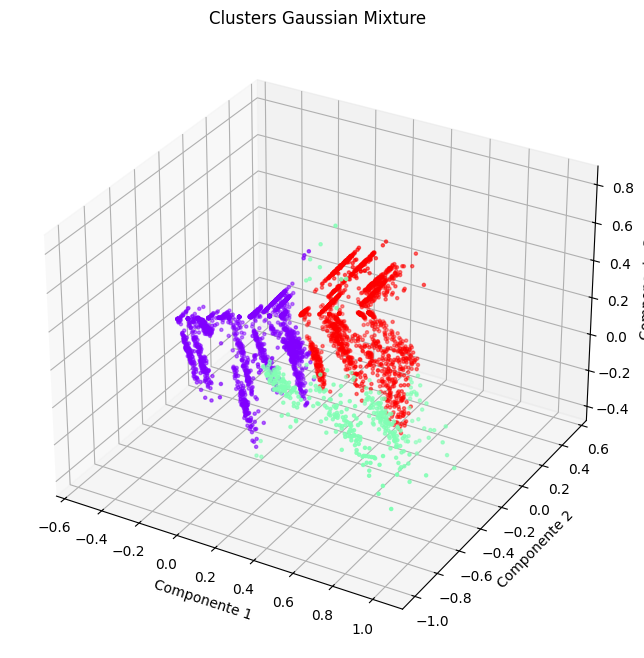

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_2_pca[:,0], x_2_pca[:,1], x_2_pca[:,2], c=labels_kmeans_pca, cmap='rainbow', s=5)
ax.set_title('Clusters Gaussian Mixture')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.show()

Hipótesis para K-Means y PCA

Hipótesis nula (H₀):
La aplicación de reducción de dimensionalidad mediante PCA no tiene un impacto significativo en la calidad del clustering generado por el algoritmo K-Means.

Hipótesis alternativa (H₁):
La aplicación de PCA mejora significativamente la calidad del clustering generado por K-Means.

Resultados observados

| Configuración | Número de clusters | Puntos ruido | Inercia | Silhouette Score |
| ------------- | ------------------ | ------------ | ------- | ---------------- |
| **Sin PCA**   | 3                  | 0            | 358.17  | 0.3378           |
| **Con PCA**   | 3                  | 0            | 316.54  | 0.3921           |


Análisis e interpretación

En ambos casos, K-Means encuentra tres clusters, sin puntos etiquetados como ruido.

El uso de PCA reduce la inercia (de 358.17 a 316.54), lo que implica que los puntos están más cerca de sus respectivos centroides tras la transformación.

El Silhouette Score aumenta al aplicar PCA (de 0.3378 a 0.3921), lo que sugiere que los clusters son más compactos y mejor separados.

Visualmente, la representación 3D tras PCA muestra una segmentación más clara.

Conclusión

En el caso del algoritmo K-Means, la aplicación de PCA mejora tanto la cohesión como la separación de los clusters, como lo evidencian la reducción de la inercia y el aumento del Silhouette Score.

Por lo tanto, se rechaza la hipótesis nula (H₀) y se acepta la hipótesis alternativa (H₁). Es decir, en este caso, el uso de PCA sí mejora de forma significativa la calidad del clustering generado por el algoritmo K-Means.



## **Análisis final**

In [ ]:
import joblib

# Guardar el mejor modelo entrenado
joblib.dump(gaussian_pca, 'gaussian_pca_model.pkl')

['gaussian_pca_model.pkl']

In [ ]:
import joblib

# Guardar el mejor modelo entrenado
joblib.dump(gaussian_pca, 'gaussian_pca_model.pkl')

In [ ]:
joblib.dump(pca_final, 'pca_model.pkl')


['pca_model.pkl']

In [ ]:
joblib.dump(scale, 'minmax_scaler.pkl')

['minmax_scaler.pkl']

In [ ]:
tabla ={
    'Modelo': ['DBSCAN', 'DBSCAN con PCA', 'Gaussian Mixture', 'Gaussian Mixture con PCA', 'K-Means', 'K-Means con PCA'],
    'Silhouette Score': [sil_dbscan_no_pca, sil_dbscan_pca, sil_gaussian_no_pca, sil_gaussian_pca, sil_kmeans_no_pca, sil_kmeans_pca],
    'Número de clusters': [num_clusters_dbscan, num_clusters_dbscan_pca, num_clusters_gaussian, num_clusters_gaussian_pca, num_clusters_kmeans, num_clusters_kmeans_pca],
    'Número de elementos en ruido': [num_ruido_dbscan, num_ruido_dbscan_pca, num_ruido_gaussian, num_ruido_gaussian_pca, num_ruido_kmeans, num_ruido_kmeans_pca],
}

df_tabla = pd.DataFrame(tabla)
print(df_tabla)

                     Modelo  Silhouette Score  Número de clusters  \
0                    DBSCAN          0.482683                   2   
1            DBSCAN con PCA          0.449448                   2   
2          Gaussian Mixture          0.398568                   2   
3  Gaussian Mixture con PCA          0.386182                   3   
4                   K-Means          0.337840                   3   
5           K-Means con PCA          0.392093                   3   

   Número de elementos en ruido  
0                             2  
1                             2  
2                             0  
3                             0  
4                             0  
5                             0  


De acuerdo con el método silueta, que se encarga de evaluar la calidad de los modelos y ver qué tan bien se han agrupado los clusters, el mejor modelo es DBSCAN porque es el más cercano a 1 indicando que es el mejor modelo agrupado. Sin embargo, observando las gráficas de dispersión, el DBSCAN no demuestra una clasificación ideal de los puntos en los clusters al asignar solo 2 puntos en una agrupación; por lo mismo, se considera mejor los modelos de k-means con PCA y Gaussian Mixture con PCA los cuales se visualiza la repartición de elementos entre los clusters. Teniendo en cuenta esto último, usaremos el modelo Gaussian Mixture con PCA por su claisficación ideal de elementos visualmente y por tener un mejor valor en el método silueta que K-means.

Hipotesis de construcción de modelos

| Modelo           | Visitas | Logins | Dispositivos Nuevos | Sesiones | Consumidores | Zonas Wifi distintas | Barrios distintos |
| ---------------- | ------- | ------ | ------------------- | -------- | ------------ | -------------------- | ----------------- |
| DBSCAN\_PCA\_0   | 28.44   | 25.83  | 2.72                | 12.06    | 26.72        | 3                    | 3                 |
| DBSCAN\_PCA\_1   | 13.13   | 11.89  | 1.40                | 6.58     | 12.83        | 5                    | 5                 |
| GMM\_PCA\_0      | 18.56   | 17.28  | 1.94                | 8.61     | 17.47        | 2                    | 2                 |
| GMM\_PCA\_1      | 11.08   | 9.81   | 1.19                | 5.53     | 10.81        | 2                    | 2                 |
| GMM\_PCA\_2      | 30.11   | 27.55  | 2.86                | 12.87    | 27.93        | 4                    | 4                 |
| KMeans\_PCA\_0   | 11.08   | 9.81   | 1.19                | 5.53     | 10.81        | 2                    | 2                 |
| KMeans\_PCA\_1   | 30.11   | 27.55  | 2.86                | 12.87    | 27.93        | 4                    | 4                 |
| KMeans\_PCA\_2   | 18.56   | 17.28  | 1.94                | 8.61     | 17.47        | 2                    | 2                 |
| DBSCAN\_noPCA\_0 | 28.44   | 25.83  | 2.72                | 12.06    | 26.72        | 3                    | 3                 |
| DBSCAN\_noPCA\_1 | 13.13   | 11.89  | 1.40                | 6.58     | 12.83        | 5                    | 5                 |
| GMM\_noPCA\_0    | 30.11   | 27.55  | 2.86                | 12.87    | 27.93        | 4                    | 4                 |
| GMM\_noPCA\_1    | 18.56   | 17.28  | 1.94                | 8.61     | 17.47        | 2                    | 2                 |
| GMM\_noPCA\_2    | 11.08   | 9.81   | 1.19                | 5.53     | 10.81        | 2                    | 2                 |
| KMeans\_noPCA\_0 | 11.08   | 9.81   | 1.19                | 5.53     | 10.81        | 2                    | 2                 |
| KMeans\_noPCA\_1 | 18.56   | 17.28  | 1.94                | 8.61     | 17.47        | 2                    | 2                 |
| KMeans\_noPCA\_2 | 30.11   | 27.55  | 2.86                | 12.87    | 27.93        | 4                    | 4                 |
